<a href="https://colab.research.google.com/github/DrMuzi/Belajar-Machine-Learning/blob/main/Natural_Language_Processing%20Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Activation, Dense, Dropout, Input

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [4]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

In [5]:
X_train

0                                  i didnt feel humiliated
1        i can go from feeling so hopeless to so damned...
2         im grabbing a minute to post i feel greedy wrong
3        i am ever feeling nostalgic about the fireplac...
4                                     i am feeling grouchy
                               ...                        
15995    i just had a very brief time in the beanbag an...
15996    i am now turning and i feel pathetic that i am...
15997                       i feel strong and good overall
15998    i feel like this was such a rude comment and i...
15999    i know a lot but i feel so stupid because i ca...
Name: Text, Length: 16000, dtype: object

In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [8]:
X_train = df_train['Text'].apply(clean)
X_test = df_test['Text'].apply(clean)
X_val = df_val['Text'].apply(clean)

In [9]:
X_train

0                                        didnt feel humili
1        go feel hopeless damn hope around someon care ...
2                     im grab minut post feel greedi wrong
3           ever feel nostalg fireplac know still properti
4                                             feel grouchi
                               ...                        
15995        brief time beanbag said anna feel like beaten
15996     turn feel pathet still wait tabl sub teach degre
15997                              feel strong good overal
15998                       feel like rude comment im glad
15999                         know lot feel stupid portray
Name: Text, Length: 16000, dtype: object

In [10]:
print(df_train['Emotion'].value_counts())
print(df_test['Emotion'].value_counts())
print(df_val['Emotion'].value_counts())

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64


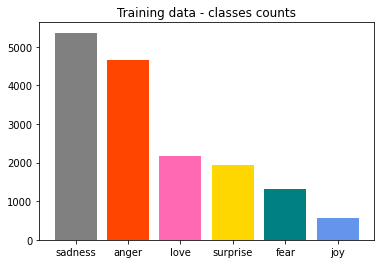

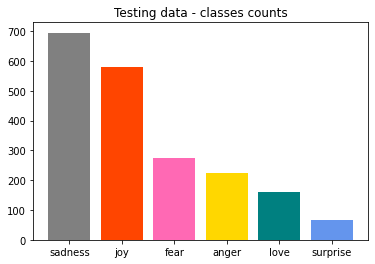

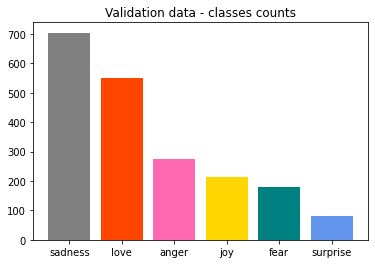

In [11]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(),height=y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(),height=y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(),height=y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [13]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [14]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))


sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")



Vocabulary size = 11002


In [15]:
# Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/Proa-ML/Week6/assignment/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 7243 words (3758 misses)


In [17]:
X_train.shape[0]

16000

In [30]:
# Build neural network architecture

adam = Adam(learning_rate=0.005)
#code here
max_words = 1000
max_len = 256

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(vocabSize,200,input_length=max_len)(inputs)
    layer = LSTM(256, return_sequences=True)(layer)
    layer = Dropout(0.2)(layer)
    layer = LSTM(128)(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('sigmoid')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(6,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 256)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 256, 200)          2200400   
                                                                 
 lstm_5 (LSTM)               (None, 256, 256)          467968    
                                                                 
 dropout_3 (Dropout)         (None, 256, 256)          0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 FC1 (Dense)                 (None, 256)               3302

In [20]:
#Callback
callback = EarlyStopping(
    #code here (contains at least : monitor, patience, restore_best_weights)
    monitor='loss',patience=5, restore_best_weights=True, verbose=1
)

In [31]:
# Fit model
# code here
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    batch_size=256,
                    epochs=15,
                    callbacks=[callback])

Epoch 1/15
63/63 [==============================] - 11s 128ms/step - loss: 1.5675 - accuracy: 0.3957 - val_loss: 1.0913 - val_accuracy: 0.6150
Epoch 2/15
63/63 [==============================] - 7s 118ms/step - loss: 0.7793 - accuracy: 0.7391 - val_loss: 0.5218 - val_accuracy: 0.8515
Epoch 3/15
63/63 [==============================] - 8s 120ms/step - loss: 0.3294 - accuracy: 0.8966 - val_loss: 0.2824 - val_accuracy: 0.9035
Epoch 4/15
63/63 [==============================] - 7s 119ms/step - loss: 0.1852 - accuracy: 0.9338 - val_loss: 0.2797 - val_accuracy: 0.9025
Epoch 5/15
63/63 [==============================] - 7s 117ms/step - loss: 0.1283 - accuracy: 0.9527 - val_loss: 0.3157 - val_accuracy: 0.8945
Epoch 6/15
63/63 [==============================] - 7s 116ms/step - loss: 0.0988 - accuracy: 0.9628 - val_loss: 0.3683 - val_accuracy: 0.8865
Epoch 7/15
63/63 [==============================] - 7s 114ms/step - loss: 0.0821 - accuracy: 0.9698 - val_loss: 0.3713 - val_accuracy: 0.8910
Epoch

In [32]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 1s 15ms/step - loss: 0.4552 - accuracy: 0.9085


[0.4551747739315033, 0.9085000157356262]

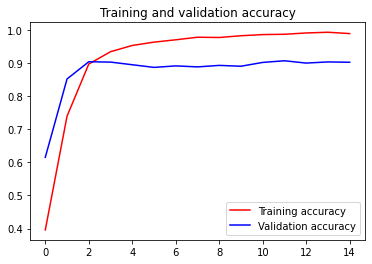

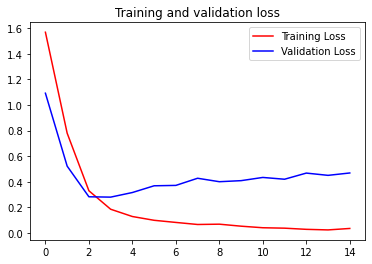

In [33]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
# Classify custom sample

sentences = [
            "I am enjoying daily life"
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

I am enjoying daily life
1 : 0.9789562821388245



In [35]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')